Import

In [ ]:
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from imblearn.over_sampling import SMOTE
from keras.callbacks import LearningRateScheduler
from keras.regularizers import l1

Load dataset

In [ ]:
data = pd.read_csv('/content/diabetes.csv')

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [ ]:
correlation_matrix = data.corr()
correlation_matrix
# Display the correlation values between features and 'Glucose'
correlation_with_glucose = correlation_matrix['Outcome'].sort_values(ascending=False)
print(correlation_with_glucose)

Outcome                     1.000000
Glucose                     0.466581
BMI                         0.292695
Age                         0.238356
Pregnancies                 0.221898
DiabetesPedigreeFunction    0.173844
Insulin                     0.130548
SkinThickness               0.074752
BloodPressure               0.065068
Name: Outcome, dtype: float64


In [ ]:
correlation_threshold = 0.22
selected_features = correlation_with_glucose[abs(correlation_with_glucose) >= correlation_threshold].index
data_selected = data[selected_features]
print(data_selected.head())


   Outcome  Glucose   BMI  Age  Pregnancies
0        1      148  33.6   50            6
1        0       85  26.6   31            1
2        1      183  23.3   32            8
3        0       89  28.1   21            1
4        1      137  43.1   33            0


In [ ]:
features = data_selected.drop('Outcome',axis=1)
target = data_selected['Outcome']

In [ ]:
scaler = StandardScaler()
X_normalized = scaler.fit_transform(features)
#X_normalized = scaler.fit_transform(data_selected)

In [ ]:
X_train,X_test,y_train, y_test = train_test_split(X_normalized,target,test_size=0.15,random_state =200)


In [ ]:
oversampler = SMOTE(random_state=200)
X_train_oversampled, y_train_oversampled = oversampler.fit_resample(X_train, y_train)

Build Model

In [ ]:
# model = Sequential([
#     Dense(64, activation='relu', input_shape=(8,)),
#     BatchNormalization(),
#     Dropout(0.3),
#     Dense(32, activation='relu'),
#     Dropout(0.3),
#     Dense(16, activation='relu'),
#     Dropout(0.3),
#     Dense(1, activation='sigmoid')
# ])
# model.summary()

In [ ]:
model = Sequential([
    Dense(128, activation="relu", input_shape=(X_train.shape[1],), kernel_regularizer=l1(0.001)),
    BatchNormalization(),
    #Dropout(0.25),
    Dense(64, activation="relu"),
    Dropout(0.25),
    Dense(32, activation="relu"),
    Dense(16, activation="relu"),
    BatchNormalization(),
    Dense(1, activation="sigmoid")
])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 128)               640       
                                                                 
 batch_normalization_6 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dense_16 (Dense)            (None, 64)                8256      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_17 (Dense)            (None, 32)                2080      
                                                                 
 dense_18 (Dense)            (None, 16)                528       
                                                      

In [ ]:
# initial_learning_rate = 0.00001
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate,
#     decay_steps=1000,
#     decay_rate=0.95,
#     staircase=True)

In [ ]:
optimizer = Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])


In [ ]:
def scheduler(epoch,learning_rate):
  if epoch<40:
    return 0.005
  learning_rate *= .993
  return learning_rate
lr_scheduler = LearningRateScheduler(scheduler)

In [ ]:
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
history = model.fit(X_train, y_train, epochs=200, batch_size=40, validation_split=0.18, verbose=1, callbacks=[lr_scheduler,es])

Epoch 1/200
14/14 [==============================] - 2s 25ms/step - loss: 0.7378 - accuracy: 0.6798 - val_loss: 0.6745 - val_accuracy: 0.6864 - lr: 0.0050
Epoch 2/200
14/14 [==============================] - 0s 5ms/step - loss: 0.5556 - accuracy: 0.7734 - val_loss: 0.6559 - val_accuracy: 0.6780 - lr: 0.0050
Epoch 3/200
14/14 [==============================] - 0s 6ms/step - loss: 0.5326 - accuracy: 0.7622 - val_loss: 0.6590 - val_accuracy: 0.6271 - lr: 0.0050
Epoch 4/200
14/14 [==============================] - 0s 7ms/step - loss: 0.5066 - accuracy: 0.7678 - val_loss: 0.6732 - val_accuracy: 0.6356 - lr: 0.0050
Epoch 5/200
14/14 [==============================] - 0s 5ms/step - loss: 0.5240 - accuracy: 0.7622 - val_loss: 0.6605 - val_accuracy: 0.6102 - lr: 0.0050
Epoch 6/200
14/14 [==============================] - 0s 5ms/step - loss: 0.4982 - accuracy: 0.7547 - val_loss: 0.6510 - val_accuracy: 0.6271 - lr: 0.0050
Epoch 7/200
14/14 [==============================] - 0s 5ms/step - loss: 0.

In [ ]:
model.evaluate(X_test,y_test)

4/4 [==============================] - 0s 3ms/step - loss: 0.5495 - accuracy: 0.7500


[0.5495381355285645, 0.75]

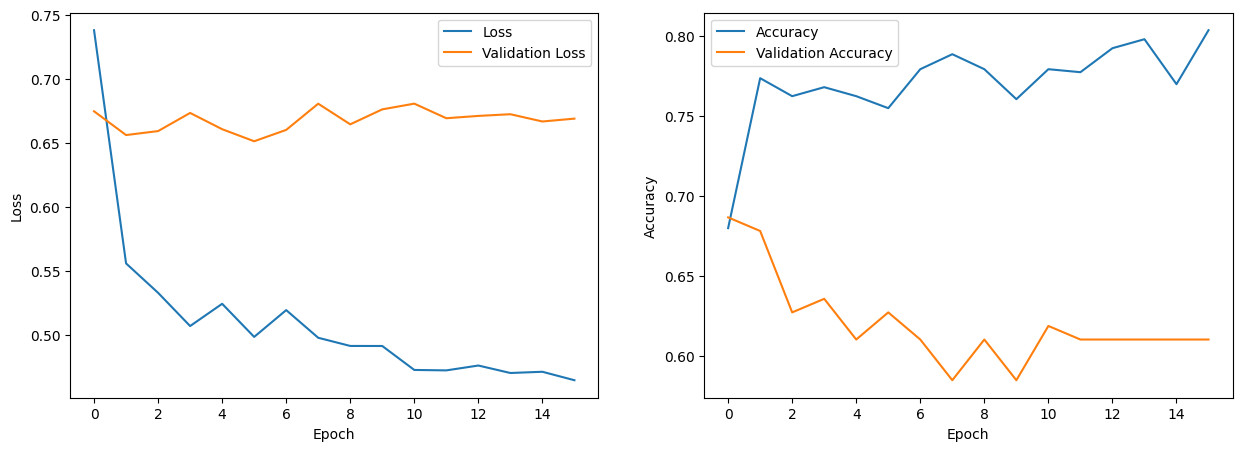

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(loss, label='Loss')
ax1.plot(val_loss, label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(accuracy, label='Accuracy')
ax2.plot(val_accuracy, label='Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.show()